In [141]:
import import_ipynb
from BankFindSearch import search
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import shap

In [142]:
#quantitative variables that idealy aren't redundant
numeric_cols = ['ASSET', 'DEP', 'EQ', 'OFFICES']

#categorical variables that can be represented with binary indicators
flag_cols = ['CB', 'CHRTAGNT',  'CFPBFLAG', 'FEDCHRTR',
            'FORM31', 'HCTMULT', 'IBA', 'INSCOML', 'INSSAVE', 'MDI_STATUS_DESC', 'REGAGNT', 'SPECGRP',  'STCHRTR', 'SUBCHAPS',
            'TRACT', 'TRUST']

cols = numeric_cols + flag_cols

#all variables includes the target or dependent variable, ROA
variables = flag_cols + ['ROA']

# Model 1

##### This model will consider active banks only and will only use the categorical/binary indicator variables (```flag_cols```)

In [143]:
#collect data from API for all active banks
r = search("institutions", 'ACTIVE:1', variables)

In [144]:
#load search result into pandas dataframe
frame = pd.DataFrame(r, columns = variables)

In [145]:
#drop missing values
data = frame.dropna()

In [146]:
data.head()

,CB,CHRTAGNT,CFPBFLAG,FEDCHRTR,FORM31,HCTMULT,IBA,INSCOML,INSSAVE,MDI_STATUS_DESC,REGAGNT,SPECGRP,STCHRTR,SUBCHAPS,TRACT,TRUST,ROA
0,1,STATE,0,0,0,,0,1,0,NONE,FDIC,4.0,1,0,0,0,0.63
1,1,STATE,0,0,0,,0,1,0,NONE,FDIC,4.0,1,1,0,0,2.74
2,1,STATE,0,0,0,,0,1,0,NONE,FDIC,4.0,1,1,0,0,0.86
3,1,STATE,0,0,0,1,0,1,0,NONE,FDIC,2.0,1,0,0,0,1.44
4,1,OCC,0,1,0,,0,1,0,NONE,OCC,4.0,0,0,1,1,1.28


In [147]:
#Map all categorical variables to binary indicators if necessary, and map all strings '1's to integers
cdata = data.drop('SPECGRP', axis = 1)
cdata['CHRTAGNT'] = data['CHRTAGNT'].map(lambda x: 1 if x == 'STATE' else 0)
cdata['MDI_STATUS_DESC'] = data['MDI_STATUS_DESC'].map(lambda x: 0 if x == "NONE" else 1)
cdata['REGAGNT'] = data['REGAGNT'].map(lambda x: 0 if x == "FDIC" else 1)
cdata['COMLS'] = data['SPECGRP'].map(lambda x: 1 if x == 4 else 0)
cdata['AGRS'] = data['SPECGRP'].map(lambda x: 1 if x == 2 else 0)
cdata['CONLS'] = data['SPECGRP'].map(lambda x: 1 if x == 6 else 0)
cdata['CCS'] = data['SPECGRP'].map(lambda x: 1 if x == 3 else 0)
cdata['INTLS'] = data['SPECGRP'].map(lambda x: 1 if x == 1 else 0)
cdata['MRLS'] = data['SPECGRP'].map(lambda x: 1 if x == 5 else 0)
cdata['OOBS'] = data['SPECGRP'].map(lambda x: 1 if x == 9 else 0)
cdata['CB'] = data['CB'].map(lambda x: 1 if x == '1' else 0)
cdata['FORM31'] = data['FORM31'].map(lambda x: 1 if x == '1' else 0)
cdata['HCTMULT'] = data['HCTMULT'].map(lambda x: 1 if x == '1' else 0)
cdata['TRACT'] = data['TRACT'].map(lambda x: 1 if x == '1' else 0)
cdata['TRUST'] = data['TRUST'].map(lambda x: 1 if x == '1' else 0)
cdata['SUBCHAPS'] = data['SUBCHAPS'].map(lambda x: 1 if x == '1' else 0)
cdata.head()

,CB,CHRTAGNT,CFPBFLAG,FEDCHRTR,FORM31,HCTMULT,IBA,INSCOML,INSSAVE,MDI_STATUS_DESC,...,TRACT,TRUST,ROA,COMLS,AGRS,CONLS,CCS,INTLS,MRLS,OOBS
0,1,1,0,0,0,0,0,1,0,0,...,0,0,0.63,1,0,0,0,0,0,0
1,1,1,0,0,0,0,0,1,0,0,...,0,0,2.74,1,0,0,0,0,0,0
2,1,1,0,0,0,0,0,1,0,0,...,0,0,0.86,1,0,0,0,0,0,0
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1.44,0,1,0,0,0,0,0
4,1,0,0,1,0,0,0,1,0,0,...,1,1,1.28,1,0,0,0,0,0,0


In [148]:
#shuffle data and partition inputs and targets
cdata_shuff =  cdata.sample(frac=1, random_state=42)
inputs = cdata_shuff.drop('ROA', axis = 1)

#here, ROA is converted to a binary indicator variable 
#target is 1 if ROA > 1%, 0 otherwise
#1% is chosen to balance the data with 1s and 0s
#choosing >0% (postitive/negative)indicator, while more intuitive, would lead to 96-4 split, very unbalanced
targets = [0 if x < 1  else 1 for x in cdata_shuff['ROA']]

In [149]:
#check for balance 
sum(targets) / len(targets)

0.5863461926883458

In [150]:
#split data into train and test
train, test = train, test = train_test_split(inputs, test_size=0.10, shuffle=False)

train_targets = targets[:len(train)]
test_targets = targets[len(train):]

In [151]:
#load data into xgb matrix
dtrain = xgb.DMatrix(train, label=train_targets)
dtest = xgb.DMatrix(test, label=test_targets)

In [152]:
#run xgb train on data
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 10
bst = xgb.train(param, dtrain, num_round)

[14:24:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [153]:
#generate predictions based on model for test dataset
preds = bst.predict(dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

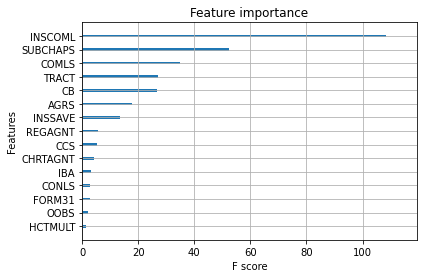

In [154]:
#plot default feature importance - not as good as shap output
xgb.plot_importance(bst, importance_type = 'gain', show_values = False)

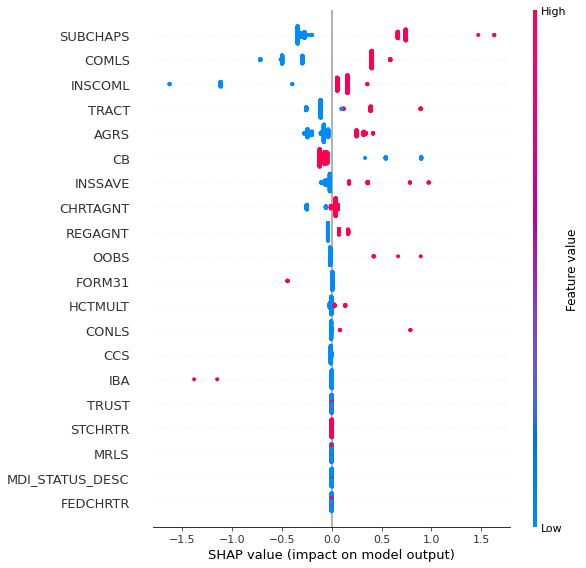

In [155]:
#print shap output - very helpful for understanding variable importance...
#esp since above 'gains' metric is not ideal - also gives sense of in which direction...
#these variables influence ROA (positive or negative)
shape_values = shap.TreeExplainer(bst).shap_values(test)
shap.summary_plot(shape_values, test)

In [156]:
#print both train and test accuracy
train_preds = [1 if x >= .5 else 0 for x in bst.predict(dtrain)]
test_preds = [1 if x >= .5 else 0 for x in preds]
train_accuracy = accuracy_score(train_targets, train_preds)
test_accuracy = accuracy_score(test_targets, test_preds)
print(f'Train accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')

Train accuracy: 0.679685746352413
Test accuracy: 0.6794354838709677


### Summary
#### This model considered only active banks
#### This model considered only categorical variables 
#### Model Accuracy = 68%
##### 68% accuracy is better than our preliminary 60%, so we are on the right track. However, we hope to still do better than this. There is certaintly a lot of variability to account for, but 70-75% accuracy is a reasonable goal moving forward

# Model 2

##### This model will consider active banks only and will use both the categorical/binary indicator variables and the quantitative variables(```flag_cols``` and ```numeric_cols```)

In [157]:
#search for all active banks, asking for only the numeric fields we are interested in
num_r = search("institutions", 'ACTIVE:1', numeric_cols)

In [158]:
#load search result into pandas dataframe
new_frame = pd.DataFrame(num_r, columns = numeric_cols)

#drop missing values
num_frame = new_frame.dropna()

#cast the numeric data to floats (since they are returned as strings for some reason)
new_data= num_frame.copy()
new_data['ASSET'] = pd.to_numeric(num_frame['ASSET'], downcast = "float")
new_data['DEP'] = pd.to_numeric(num_frame['DEP'], downcast = "float")
new_data['EQ'] = pd.to_numeric(num_frame['EQ'], downcast = "float")
new_data['OFFICES'] = pd.to_numeric(num_frame['OFFICES'], downcast = "float")

In [159]:
#scale our quantitative data
#this data is important to scale so variables of much higher magnitude don't receive extra weight
#note that we do no do this for the indicator variables since this data is inherently low in magnitude...
#...and doing so would also make weights much harder to interpret

scaler = preprocessing.StandardScaler()
scaled_num_data = scaler.fit_transform(new_data)
scaled_num_data = pd.DataFrame(scaled_num_data, columns=numeric_cols)

In [160]:
#combine the scaled numertic data with the categorical data from Model 2
join_data = scaled_num_data.join(cdata)

In [161]:
#drop any new missings values
#this is necessary since some missing values were uncovered after casting numeric vars...
#...from strings to floats - they were being stored as empty strings
new_cdata = join_data.dropna()

In [162]:
#shuffle data, preparing to train-test split
new_cdata_shuff =  new_cdata.sample(frac=1, random_state=87)

#partition targets and inputs
#once again, convert ROA to indicator, 1 if ROA > 1% by same logic as Model 2
new_inputs = new_cdata_shuff.drop('ROA', axis = 1)
new_targets = [0 if x < 1 else 1 for x in new_cdata_shuff['ROA']]

In [163]:
#check for balance 
sum(new_targets) / len(new_targets)

0.5880089122949159

In [164]:
#split into train and test datasets
new_train, new_test = train, test = train_test_split(new_inputs, test_size=0.10, shuffle=False)

new_train_targets = new_targets[:len(new_train)]
new_test_targets = new_targets[len(new_train):]

In [165]:
#load into xgb matrix
new_dtrain = xgb.DMatrix(new_train, label=new_train_targets)
new_dtest = xgb.DMatrix(new_test, label=new_test_targets)

In [166]:
#execute xgb training
param = {'max_depth': 2, 'eta':1, 'objective':'binary:logistic' }
num_round = 8
new_bst = xgb.train(param, new_dtrain, num_round)

[14:24:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [167]:
#generate predictions for test dataset
new_preds = new_bst.predict(new_dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

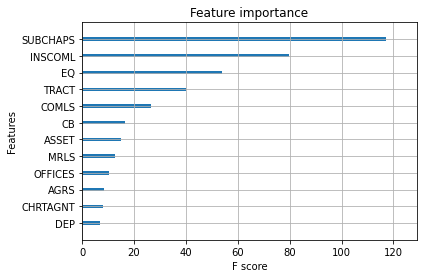

In [168]:
#plot default feature importance - not as good as shap output
xgb.plot_importance(new_bst, importance_type = 'gain', show_values = False)

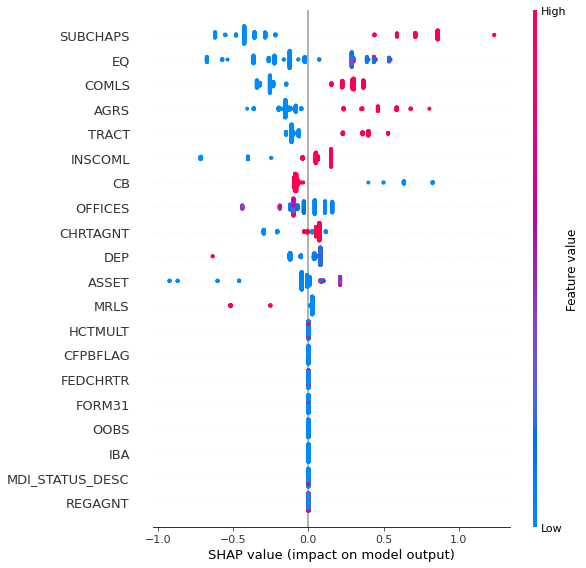

In [169]:
#print shap output - very helpful for understanding variable importance
shape_values = shap.TreeExplainer(new_bst).shap_values(new_test)
shap.summary_plot(shape_values, new_test)

In [170]:
#print both train and test accuracy
train_preds = [1 if x >= .5 else 0 for x in new_bst.predict(new_dtrain)]
test_preds = [1 if x >= .5 else 0 for x in new_preds]
train_accuracy = accuracy_score(new_train_targets, train_preds)
test_accuracy = accuracy_score(new_test_targets, test_preds)
print(f'Train accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')

Train accuracy: 0.700877785280216
Test accuracy: 0.7004048582995951


### Summary
#### This model considered only active banks
#### This model considered both quantitative and categorical variables
#### Model Accuracy = 70%
##### A slight improvement over Model 2. Since these two models ignore inactive banks, one idea is to include all banks in the dataset, which would be about 5x larger of a dataset, and see how the accuracies compare